<a href="https://colab.research.google.com/github/earltreloar/logosfield-cddr-analysis/blob/main/Mechanism2_DensityKappa_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanism 2 — Density–κ Coherence (Colab)

In [1]:
#@title 0. Setup
!pip -q install numpy pandas matplotlib healpy
import numpy as np, pandas as pd, matplotlib.pyplot as plt, healpy as hp
print("healpy", hp.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 37.3 MB/s eta 0:00:00
healpy 1.18.1


In [2]:
#@title 1. (Optional) Drive paths
USE_DRIVE=False  #@param {type:"boolean"}
kappa_fits=""    #@param {type:"string"}
mask_fits=""     #@param {type:"string"}
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
#@title 2. Load/synthesize NSIDE=128 maps
NSIDE=128; NPIX=hp.nside2npix(NSIDE)
if USE_DRIVE and kappa_fits:
    kappa = hp.read_map(kappa_fits, verbose=False)
    mask  = hp.read_map(mask_fits, verbose=False).astype(bool) if mask_fits else np.ones(NPIX,bool)
else:
    rng=np.random.default_rng(123); kappa=rng.normal(0,1e-3,NPIX)
    th,ph=hp.pix2ang(NSIDE, np.arange(NPIX)); kappa += 3e-3*np.cos(ph)*np.sin(th)
    mask=np.ones(NPIX,bool)
density = kappa*0.6 + np.random.default_rng(7).normal(0,1e-3,NPIX)
kappa[~mask]=hp.UNSEEN; density[~mask]=hp.UNSEEN
print('Maps ready.')

Maps ready.


In [4]:
#@title 3. C_ell and permutation p-value
lmax=3*NSIDE-1
cl_kk=hp.anafast(kappa, lmax=lmax); cl_dd=hp.anafast(density, lmax=lmax); cl_kd=hp.anafast(kappa, density, lmax=lmax)
ells=np.arange(len(cl_kk)); band=(ells>=30)&(ells<=240)
num=np.sum(cl_kd[band]**2); den=np.sum(cl_kk[band]*cl_dd[band]+1e-18); snr2=num/den
rng=np.random.default_rng(99); reps=200; vals=[]
valid=mask & np.isfinite(kappa) & np.isfinite(density); pix=np.where(valid)[0]
for _ in range(reps):
    perm=pix.copy(); rng.shuffle(perm)
    d_perm=np.full_like(density, hp.UNSEEN); d_perm[pix]=density[perm]
    cl_kd_p=hp.anafast(kappa, d_perm, lmax=lmax)
    num=np.sum(cl_kd_p[band]**2); vals.append(num/den)
vals=np.array(vals); p=(np.sum(vals>=snr2)+1)/(reps+1)
print(f"SNR^2_obs={snr2:.2f}; p≈{p:.3e}")

SNR^2_obs=0.00; p≈4.975e-03


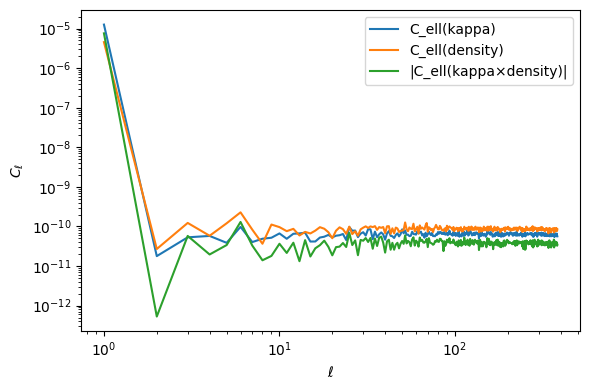

Wrote: /content/outputs_m2/summary.csv


In [5]:
#@title 4. Plot + save
plt.figure(figsize=(6,4))
plt.loglog(ells[1:], cl_kk[1:], label="C_ell(kappa)")
plt.loglog(ells[1:], cl_dd[1:], label="C_ell(density)")
plt.loglog(ells[1:], np.abs(cl_kd[1:]), label="|C_ell(kappa×density)|")
plt.legend(); plt.xlabel(r"$\ell$"); plt.ylabel(r"$C_\ell$"); plt.tight_layout(); plt.show()
out='/content/outputs_m2'; import os; os.makedirs(out, exist_ok=True)
np.savetxt(f"{out}/cl_kappa.txt", cl_kk); np.savetxt(f"{out}/cl_density.txt", cl_dd); np.savetxt(f"{out}/cl_cross.txt", cl_kd)
pd.DataFrame({'SNR2_obs':[float(snr2)],'p_value':[float(p)]}).to_csv(f"{out}/summary.csv", index=False)
print("Wrote:", f"{out}/summary.csv")